# Depth Anything V2 Comparison

Compare Depth Anything V2 models (ViT-S and ViT-B) on test set UUIDs.

**Prerequisites:**
- Activate the `depthsplat` conda environment
- Ensure pretrained weights are in `../pretrained/`

**Reference:** [Depth-Anything-V2 GitHub](https://github.com/DepthAnything/Depth-Anything-V2)

In [1]:
import os
import sys
from pathlib import Path

# Setup paths
SCRIPT_DIR = Path(os.getcwd())
DEPTHSPLAT_ROOT = SCRIPT_DIR.parent
PRETRAINED_DIR = DEPTHSPLAT_ROOT / "pretrained"
GRADIO_DIR = DEPTHSPLAT_ROOT / "inference_gradio"

# Add paths for imports
if str(GRADIO_DIR) not in sys.path:
    sys.path.insert(0, str(GRADIO_DIR))
if str(DEPTHSPLAT_ROOT) not in sys.path:
    sys.path.insert(0, str(DEPTHSPLAT_ROOT))

print(f"DepthSplat root: {DEPTHSPLAT_ROOT}")
print(f"Pretrained dir: {PRETRAINED_DIR}")

DepthSplat root: /home/sandro/aeroSplat-4D/stage-2_3DGS/depthsplat
Pretrained dir: /home/sandro/aeroSplat-4D/stage-2_3DGS/depthsplat/pretrained


In [2]:
# Depth Anything V2 repo location
DEPTH_ANYTHING_DIR = Path("/home/sandro/aeroSplat-4D/stage-2_3DGS/Depth-Anything-V2")

if not DEPTH_ANYTHING_DIR.exists():
    raise FileNotFoundError(f"Depth-Anything-V2 not found at {DEPTH_ANYTHING_DIR}")

print(f"Using Depth-Anything-V2 from {DEPTH_ANYTHING_DIR}")

# Add to path
if str(DEPTH_ANYTHING_DIR) not in sys.path:
    sys.path.insert(0, str(DEPTH_ANYTHING_DIR))

Using Depth-Anything-V2 from /home/sandro/aeroSplat-4D/stage-2_3DGS/Depth-Anything-V2


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import Depth Anything V2
from depth_anything_v2.dpt import DepthAnythingV2

# Import data loader from Gradio demo
from data_loader import (
    HARDCODED_UUIDS,
    get_example_by_uuid,
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


## Select UUID

Uncomment ONE UUID to select which test object to visualize (same UUIDs as Gradio demo).

In [4]:
# === SELECT ONE UUID BY UNCOMMENTING ===

SELECTED_UUID = "acc210f3a2544cf1b250b45eaaf80160"  # UUID 0
# SELECTED_UUID = "fcfc68f4adfa410a8b5855225a905c85"  # UUID 1
# SELECTED_UUID = "f60358d2b71646598b1b961c35261f89"  # UUID 2
# SELECTED_UUID = "00e32088111346ac84b9318b97e52c8e"  # UUID 3
# SELECTED_UUID = "cd785cd85e5d495e97185587871ff975"  # UUID 4
# SELECTED_UUID = "c6769a0400fb4496823eb5ef666adaa0"  # UUID 5
# SELECTED_UUID = "3442d066a0e249138f1e407e7e6ec30c"  # UUID 6
# SELECTED_UUID = "d9973e55e5e94e2c962d3494d848ad95"  # UUID 7
# SELECTED_UUID = "8fea3562f05345f7ba7ba7f80dbff2f5"  # UUID 8
# SELECTED_UUID = "dc0e741a15124119ae12efc17e50c593"  # UUID 9

print(f"Selected UUID: {SELECTED_UUID}")

Selected UUID: acc210f3a2544cf1b250b45eaaf80160


## Load Models

In [5]:
# Model configurations (from Depth Anything V2 repo)
MODEL_CONFIGS = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
}

# Weight paths
WEIGHT_PATHS = {
    'vits': PRETRAINED_DIR / 'depth_anything_v2_vits.pth',
    'vitb': PRETRAINED_DIR / 'depth_anything_v2_vitb.pth',
}

# Load models
models = {}

for model_name in ['vits', 'vitb']:
    print(f"Loading {model_name}...")
    model = DepthAnythingV2(**MODEL_CONFIGS[model_name])
    model.load_state_dict(torch.load(WEIGHT_PATHS[model_name], map_location='cpu'))
    model = model.to(DEVICE).eval()
    models[model_name] = model
    print(f"  Loaded from {WEIGHT_PATHS[model_name]}")

print("\nModels loaded successfully!")

Loading vits...
  Loaded from /home/sandro/aeroSplat-4D/stage-2_3DGS/depthsplat/pretrained/depth_anything_v2_vits.pth
Loading vitb...
  Loaded from /home/sandro/aeroSplat-4D/stage-2_3DGS/depthsplat/pretrained/depth_anything_v2_vitb.pth

Models loaded successfully!


## Load Test Data

In [6]:
# Dataset location (same as Gradio demo)
DATA_DIR = "/mnt/raid0/objaverse/test"

# Load example (5 context views, farthest point sampling)
example = get_example_by_uuid(DATA_DIR, SELECTED_UUID, num_context_views=5)

if example is None:
    raise ValueError(f"Failed to load UUID {SELECTED_UUID}")

print(f"Loaded: {example['key']}")
print(f"Number of views: {len(example['images'])}")
print(f"Selected indices: {example['selected_indices']}")
print(f"Image shape: {example['images'][0].shape}")

Loaded UUID acc210f3a2544cf1b250b45eaaf80160: selected views [0, 31, 15, 16, 14] from 32 total
Loaded: acc210f3a2544cf1b250b45eaaf80160
Number of views: 5
Selected indices: [0, 31, 15, 16, 14]
Image shape: (256, 256, 3)


## Run Depth Estimation

In [7]:
def estimate_depth(model, image_np):
    """
    Run depth estimation on a single image.
    
    Args:
        model: DepthAnythingV2 model
        image_np: RGB image as numpy array [H, W, 3] in uint8
    
    Returns:
        Depth map as numpy array [H, W]
    """
    with torch.no_grad():
        depth = model.infer_image(image_np)
    return depth


# Run depth estimation for all views and both models
depth_results = {model_name: [] for model_name in models}

for i, img in enumerate(example['images']):
    print(f"Processing view {i+1}/{len(example['images'])}...")
    for model_name, model in models.items():
        depth = estimate_depth(model, img)
        depth_results[model_name].append(depth)

print("\nDepth estimation complete!")

Processing view 1/5...
Processing view 2/5...
Processing view 3/5...
Processing view 4/5...
Processing view 5/5...

Depth estimation complete!


## Visualization

Display results: Top row = input context images, Bottom rows = depth estimates per model.

/tmp/ipykernel_14606/3809912765.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


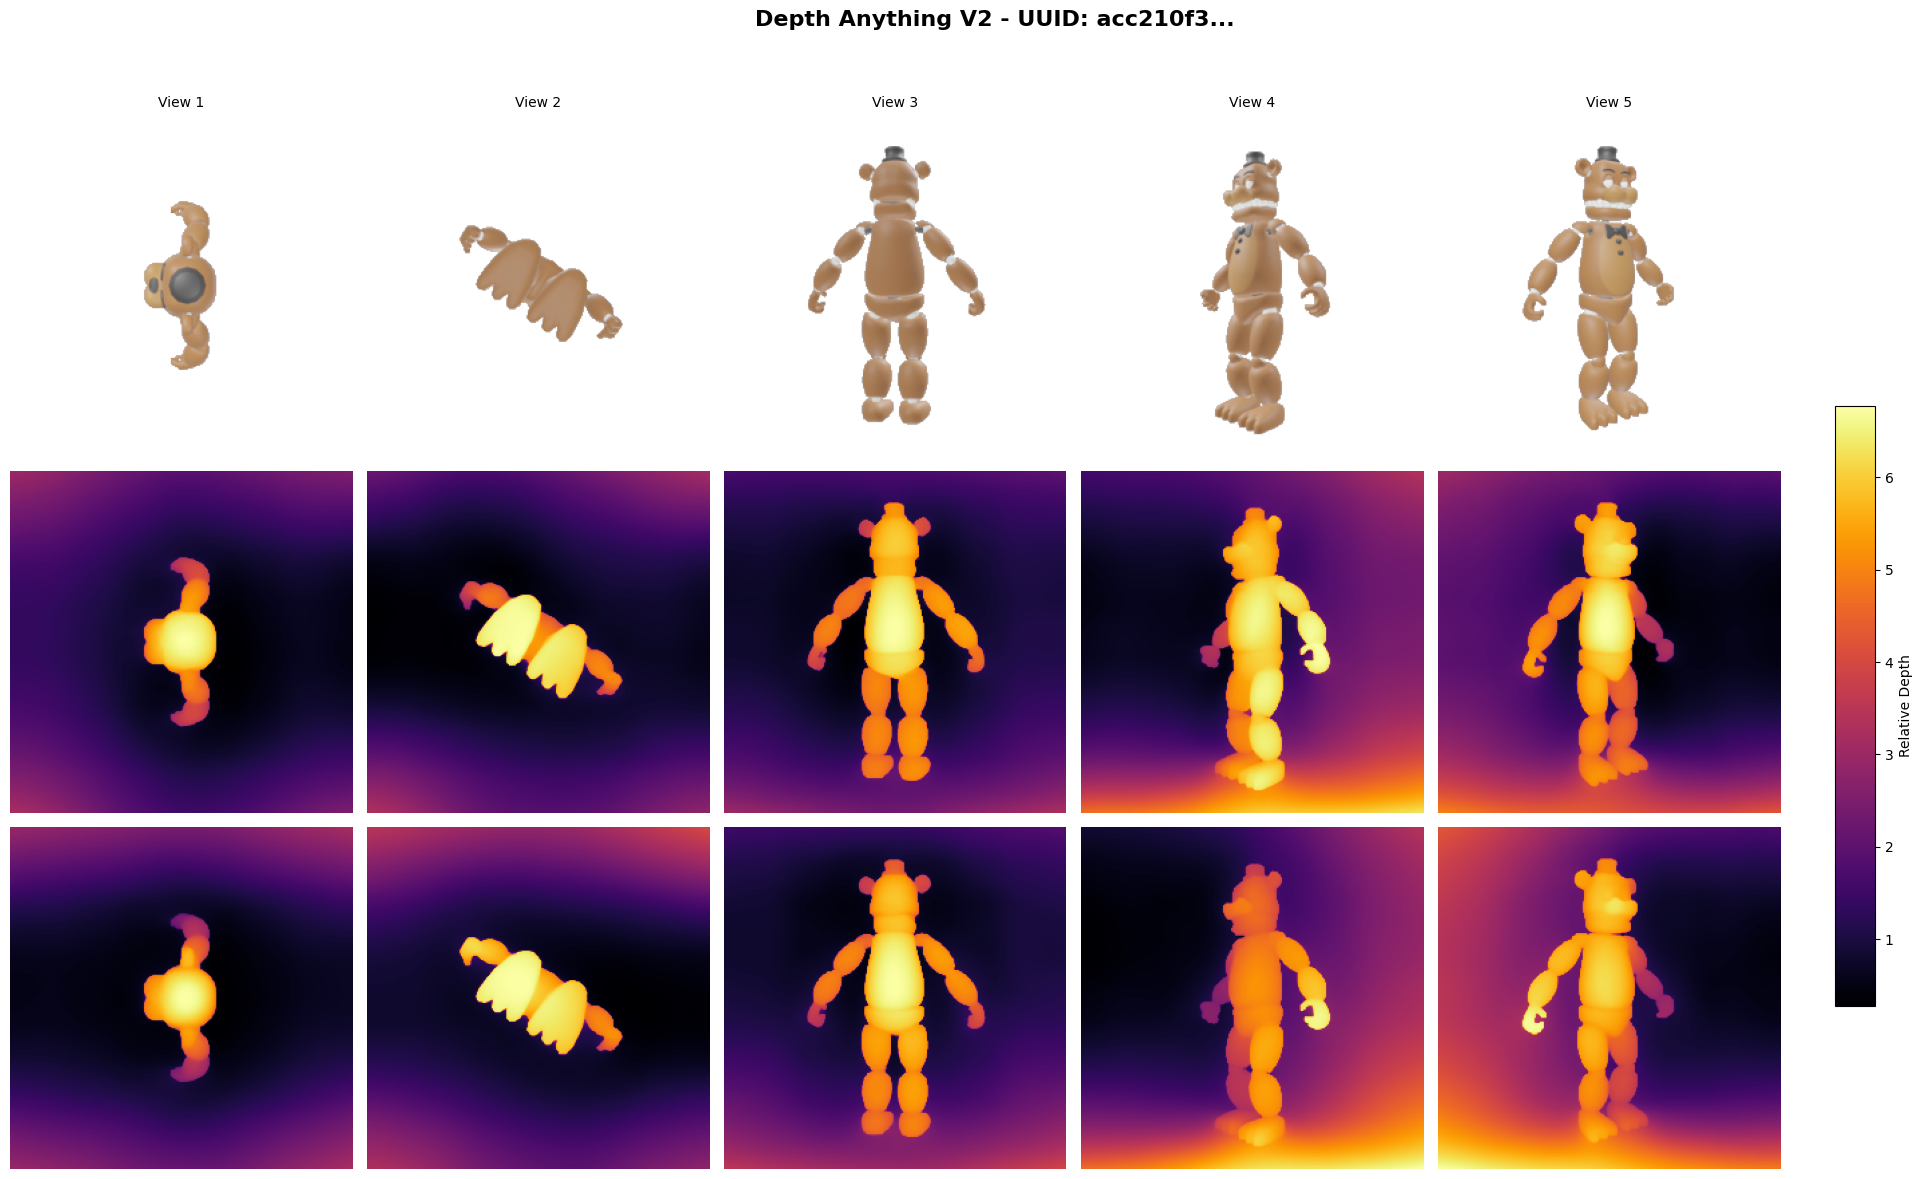

In [8]:
def visualize_depth_comparison(images, depth_results, title="Depth Anything V2 Comparison"):
    """
    Visualize input images and depth estimates in a grid.
    
    Layout:
        Row 0: Input context images
        Row 1: ViT-S depth estimates
        Row 2: ViT-B depth estimates
    """
    num_views = len(images)
    num_rows = 3  # input + 2 models
    
    fig, axes = plt.subplots(num_rows, num_views, figsize=(4 * num_views, 4 * num_rows))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    row_labels = ['Input', 'ViT-S Depth', 'ViT-B Depth']
    
    for col, img in enumerate(images):
        # Row 0: Input images
        ax = axes[0, col]
        ax.imshow(img)
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(row_labels[0], fontsize=12, fontweight='bold')
        ax.set_title(f'View {col+1}', fontsize=10)
    
    # Rows 1-2: Depth estimates
    for row_idx, model_name in enumerate(['vits', 'vitb']):
        for col, depth in enumerate(depth_results[model_name]):
            ax = axes[row_idx + 1, col]
            im = ax.imshow(depth, cmap='inferno')
            ax.axis('off')
            if col == 0:
                ax.set_ylabel(row_labels[row_idx + 1], fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax, label='Relative Depth')
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()


# Visualize
visualize_depth_comparison(
    example['images'], 
    depth_results,
    title=f"Depth Anything V2 - UUID: {SELECTED_UUID[:8]}..."
)

## Side-by-Side Comparison (Single View)

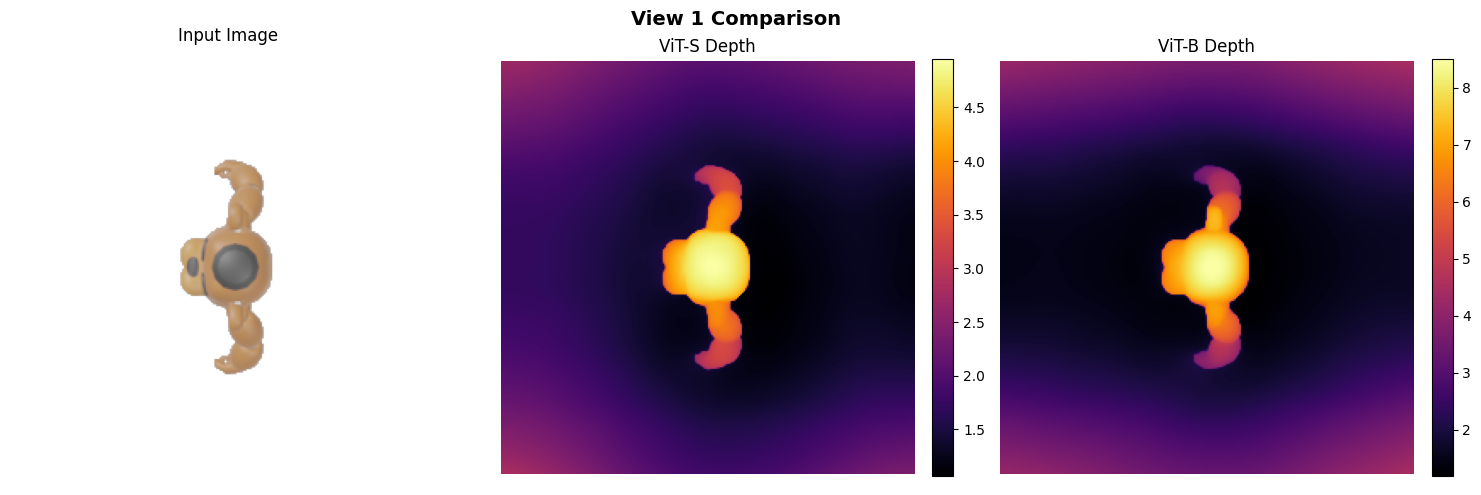

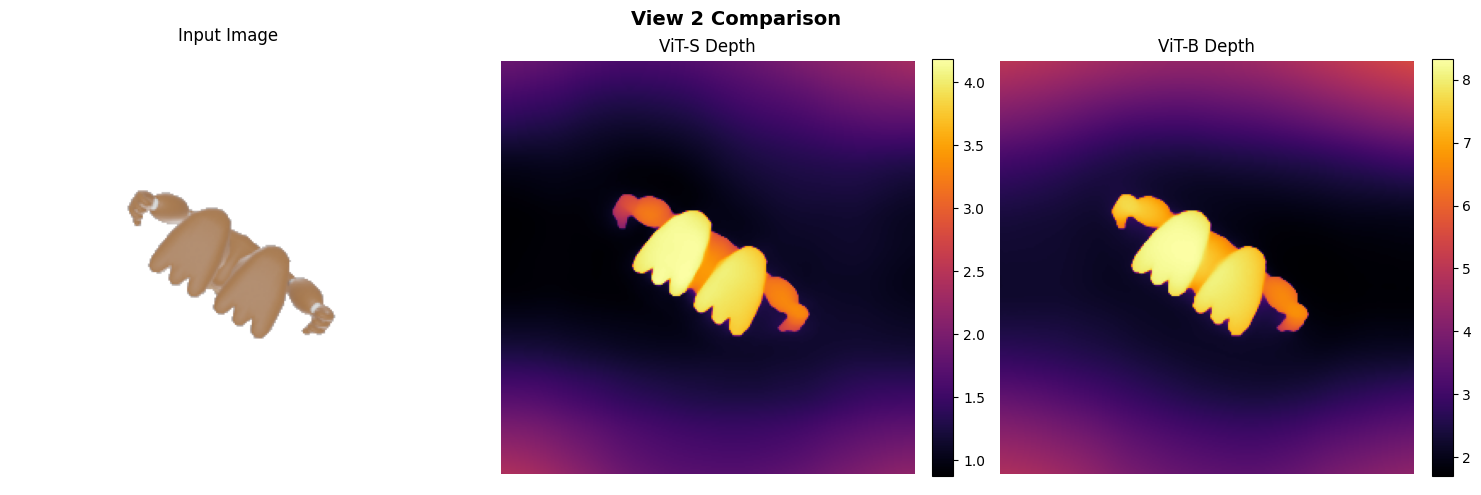

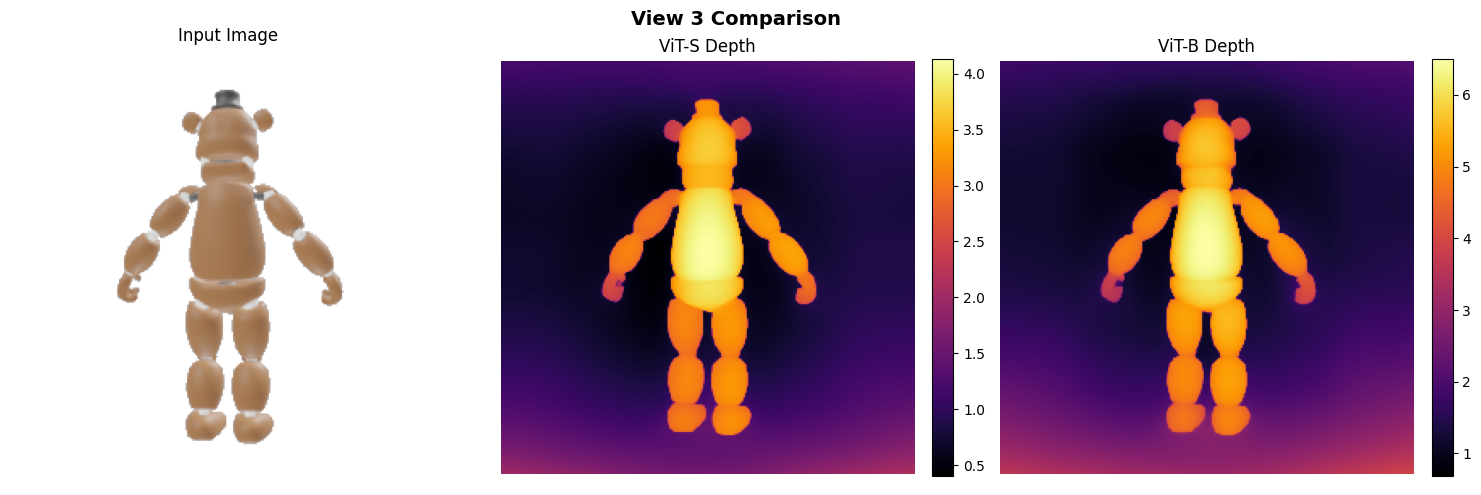

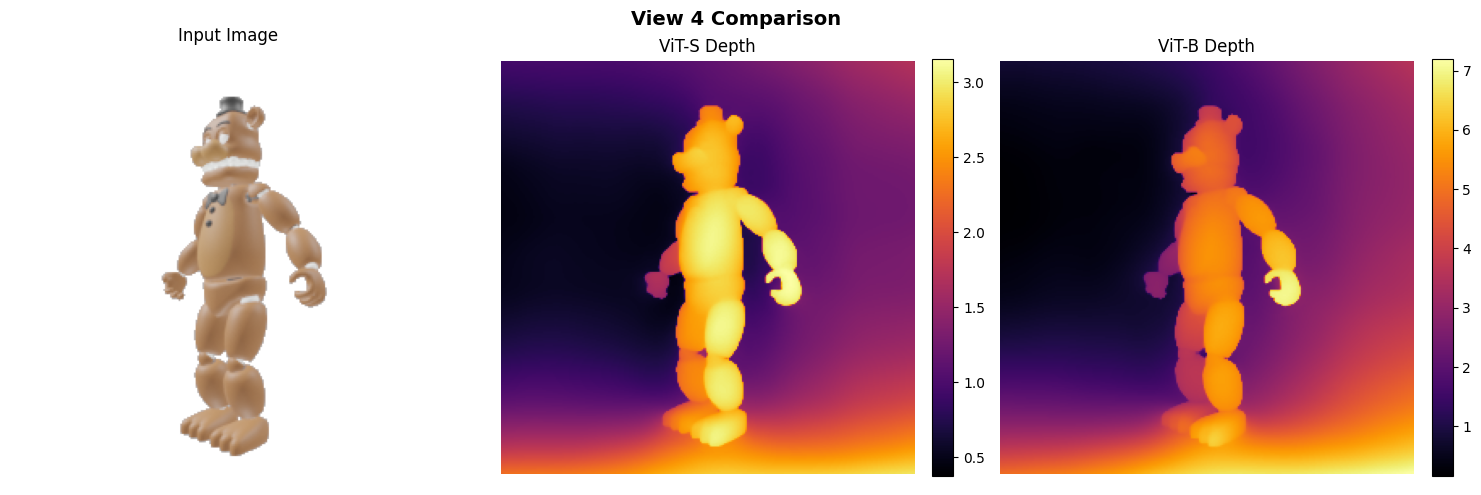

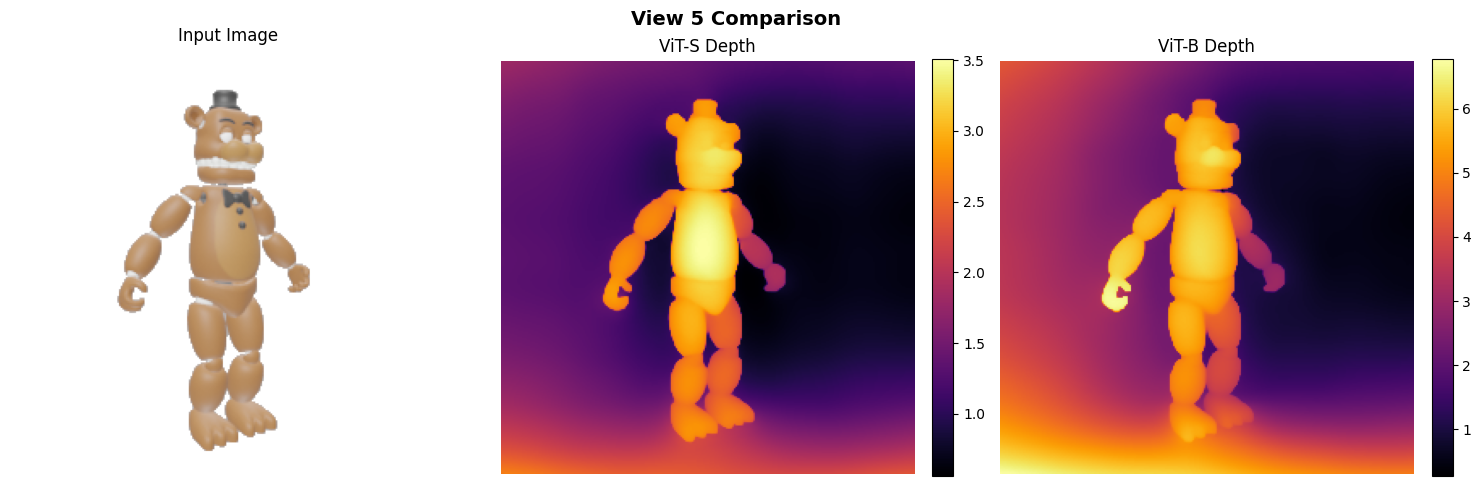

In [9]:
def visualize_single_view_comparison(image, depth_vits, depth_vitb, view_idx=0):
    """
    Detailed comparison for a single view.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Input
    axes[0].imshow(image)
    axes[0].set_title('Input Image', fontsize=12)
    axes[0].axis('off')
    
    # ViT-S Depth
    im1 = axes[1].imshow(depth_vits, cmap='inferno')
    axes[1].set_title('ViT-S Depth', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # ViT-B Depth
    im2 = axes[2].imshow(depth_vitb, cmap='inferno')
    axes[2].set_title('ViT-B Depth', fontsize=12)
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle(f'View {view_idx + 1} Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Show detailed comparison for each view
for i in range(len(example['images'])):
    visualize_single_view_comparison(
        example['images'][i],
        depth_results['vits'][i],
        depth_results['vitb'][i],
        view_idx=i
    )

## Depth Statistics

In [10]:
print("Depth Statistics per Model:")
print("=" * 60)

for model_name in ['vits', 'vitb']:
    depths = depth_results[model_name]
    all_depths = np.concatenate([d.flatten() for d in depths])
    
    print(f"\n{model_name.upper()}:")
    print(f"  Min depth: {all_depths.min():.4f}")
    print(f"  Max depth: {all_depths.max():.4f}")
    print(f"  Mean depth: {all_depths.mean():.4f}")
    print(f"  Std depth: {all_depths.std():.4f}")
    print(f"  Median depth: {np.median(all_depths):.4f}")

Depth Statistics per Model:

VITS:
  Min depth: 0.3770
  Max depth: 4.9503
  Mean depth: 1.4946
  Std depth: 0.7741
  Median depth: 1.3044

VITB:
  Min depth: 0.1683
  Max depth: 8.4998
  Mean depth: 2.6922
  Std depth: 1.5849
  Median depth: 2.3790
